In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 17s 0us/step


In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'test', 'README', 'imdbEr.txt', 'train']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_neg.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'urls_unsup.txt',
 'pos',
 'unsup',
 'unsupBow.feat',
 'neg']

In [5]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file,'r') as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## ładowanie i obróbka **zbioru danych**

In [6]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f"Recenzja: {text_batch.numpy()[i]}")
    print(f"Etykieta: {label_batch.numpy()[i]}")

Recenzja: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etykieta: 0
Recenzja: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [9]:
print(f"etykieta 0 -> {raw_train_ds.class_names[0]}")
print(f"etykieta 1 -> {raw_train_ds.class_names[1]}")

etykieta 0 -> neg
etykieta 1 -> pos


In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


PRZYGOTOWANIE ZBIORU DANYCH DO **SZKOLENIA**

In [12]:
#standardyzacja tekstu
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' %re.escape(string.punctuation),'')

In [13]:
#wartwa wektoryzacji
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [14]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [15]:
def vectorized_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [16]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(f'Recenzja: {first_review}')
print(f'Etykieta: {raw_train_ds.class_names[first_label]}')
print(f"Recenzja po wektoryzacji: {vectorized_text(first_review,first_label)}")

Recenzja: b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
Etykieta: neg
Recenzja po wektoryzacji: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  

In [17]:
print(f"1287 --> {vectorize_layer.get_vocabulary()[1287]}")
print(f"313 --> {vectorize_layer.get_vocabulary()[313]}")
print(f"404 --> {vectorize_layer.get_vocabulary()[404]}")
print(f"Rozmiar słownika: {len(vectorize_layer.get_vocabulary())}")

1287 --> silent
313 --> night
404 --> finally
Rozmiar słownika: 10000


In [18]:
train_ds = raw_train_ds.map(vectorized_text)
val_ds = raw_val_ds.map(vectorized_text)
test_ds = raw_test_ds.map(vectorized_text)

In [19]:
#konfiguracja zbioru pod kątem wydajności

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

TWORZENIE MODELU

In [20]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([

                             layers.Embedding(max_features + 1,embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics = tf.metrics.BinaryAccuracy(threshold=0.0))

In [24]:
#trenowanie modelu

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 10s 14ms/step - loss: 0.6652 - binary_accuracy: 0.6963 - val_loss: 0.6173 - val_binary_accuracy: 0.7680
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.5506 - binary_accuracy: 0.7993 - val_loss: 0.5003 - val_binary_accuracy: 0.8216
Epoch 3/10
625/625 [==============================] - 7s 12ms/step - loss: 0.4459 - binary_accuracy: 0.8446 - val_loss: 0.4215 - val_binary_accuracy: 0.8462
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3800 - binary_accuracy: 0.8650 - val_loss: 0.3748 - val_binary_accuracy: 0.8594
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3363 - binary_accuracy: 0.8770 - val_loss: 0.3459 - val_binary_accuracy: 0.8662
Epoch 6/10
625/625 [==============================] - 8s 14ms/step - loss: 0.3066 - binary_accuracy: 0.8878 - val_loss: 0.3269 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 7s 

In [25]:
loss, accuracy = model.evaluate(test_ds)
print(f'Strata: {loss}')
print(f'Dokładność: {accuracy}')

782/782 [==============================] - 4s 5ms/step - loss: 0.3103 - binary_accuracy: 0.8736
Strata: 0.31028056144714355
Dokładność: 0.8736000061035156


WYKRES DOKŁADNOŚCI I STRAT W CZASIE

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

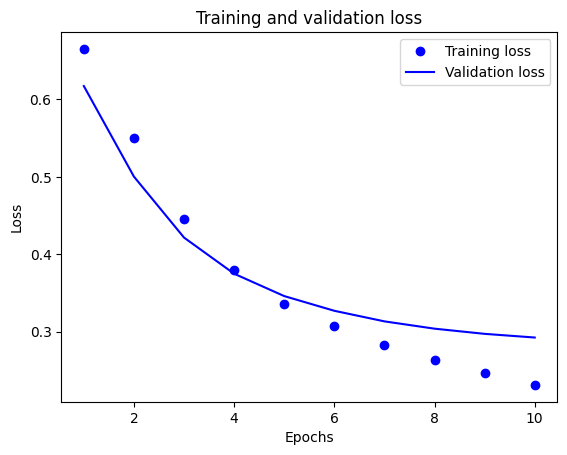

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

#"bo" - "blue dot"
#"b"  "blue line"

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

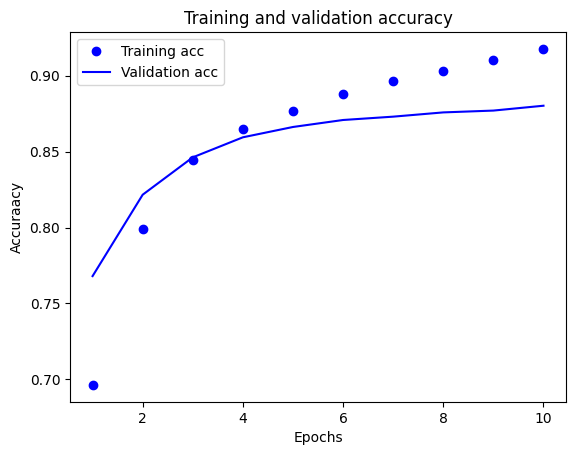

In [28]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuraacy')
plt.legend()
plt.show()